Using device: cuda

===== Training: baseline =====
attention_mode=none | guided_loss=False | head_variant=base
[baseline] Epoch 01/10 | Train: loss=0.9308 acc=0.6927 P/R/F1=0.691/0.701/0.694 AUC=0.901 | Val: loss=0.7558 acc=0.8283 P/R/F1=0.835/0.834/0.829 AUC=0.961 | lr=0.000293
✅ [baseline] New best saved @ /kaggle/working/tumornet_runs/ablation_baseline/best.pt (val_acc=0.8283)
[baseline] Epoch 02/10 | Train: loss=0.6388 acc=0.8884 P/R/F1=0.891/0.892/0.891 AUC=0.982 | Val: loss=0.6528 acc=0.8833 P/R/F1=0.887/0.889/0.884 AUC=0.979 | lr=0.000274
✅ [baseline] New best saved @ /kaggle/working/tumornet_runs/ablation_baseline/best.pt (val_acc=0.8833)
[baseline] Epoch 03/10 | Train: loss=0.5721 acc=0.9247 P/R/F1=0.926/0.927/0.926 AUC=0.990 | Val: loss=0.5729 acc=0.9288 P/R/F1=0.927/0.931/0.928 AUC=0.990 | lr=0.000244
✅ [baseline] New best saved @ /kaggle/working/tumornet_runs/ablation_baseline/best.pt (val_acc=0.9288)
[baseline] Epoch 04/10 | Train: loss=0.5371 acc=0.9456 P/R/F1=0.946/0.947

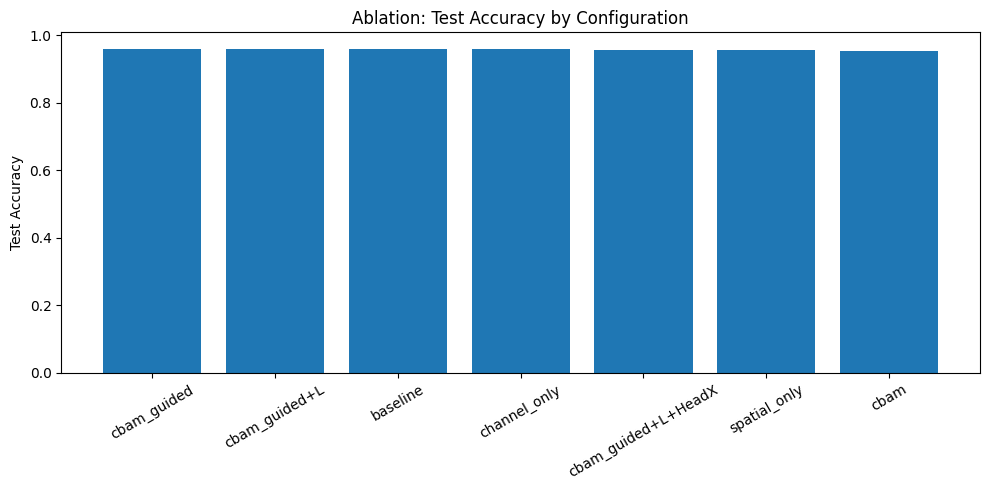


Saved summary CSV → /kaggle/working/tumornet_runs/ablation_summary.csv


In [1]:
# =========================================================
# Ablation Pipeline: Spiral CNN + GCSA (+ Heavy Classifier Head option)
# =========================================================

import os
import gc
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

# -----------------------------
# Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# -----------------------------
# Dataset
# -----------------------------
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, class_order=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.classes = class_order if class_order is not None else ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

    @staticmethod
    def load_image_paths_labels(root_dir):
        image_paths, labels = [], []
        for category in sorted(os.listdir(root_dir)):
            cat_path = os.path.join(root_dir, category)
            if os.path.isdir(cat_path):
                for img_name in os.listdir(cat_path):
                    img_path = os.path.join(cat_path, img_name)
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        image_paths.append(img_path)
                        labels.append(category)
        return image_paths, labels

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# -----------------------------
# Blocks
# -----------------------------
class GeM(nn.Module):
    def __init__(self, p: float = 3.0, eps: float = 1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.clamp(min=self.eps).pow(self.p)
        x = F.avg_pool2d(x, (x.size(-2), x.size(-1)))
        return x.pow(1.0 / self.p)

class SEBlock(nn.Module):
    def __init__(self, c: int, r: int = 16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        red = max(8, c // r)
        self.fc = nn.Sequential(
            nn.Conv2d(c, red, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(red, c, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w = self.fc(self.pool(x))
        return x * w

class ChannelAttention(nn.Module):
    def __init__(self, c: int, r: int = 16):
        super().__init__()
        red = max(8, c // r)
        self.avg_fc = nn.Sequential(nn.Conv2d(c, red, 1, bias=False), nn.ReLU(inplace=True), nn.Conv2d(red, c, 1, bias=False))
        self.max_fc = nn.Sequential(nn.Conv2d(c, red, 1, bias=False), nn.ReLU(inplace=True), nn.Conv2d(red, c, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg = torch.mean(x, dim=(2,3), keepdim=True)
        mx, _ = torch.max(x, dim=2, keepdim=True); mx, _ = torch.max(mx, dim=3, keepdim=True)
        out = self.avg_fc(avg) + self.max_fc(mx)
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, k: int = 7):
        super().__init__()
        assert k in (3,7)
        pad = 3 if k == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=pad, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, mx], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, c: int, r: int = 16, k: int = 7):
        super().__init__()
        self.ca = ChannelAttention(c, r)
        self.sa = SpatialAttention(k)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class GuidedChannelSpatialAttention(nn.Module):
    def __init__(self, c: int, r: int = 16, k: int = 7):
        super().__init__()
        self.cbam_ca = ChannelAttention(c, r)
        self.cbam_sa = SpatialAttention(k)
        red = max(16, c // 8)
        self.guidance_head = nn.Sequential(
            nn.Conv2d(c, red, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(red),
            nn.ReLU(inplace=True),
            nn.Conv2d(red, 1, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x: torch.Tensor):
        A = self.guidance_head(x)  # (B,1,H,W)
        ca = self.cbam_ca(x)
        gate = torch.mean(A, dim=(2,3), keepdim=True)
        x = x * (ca * (0.5 + gate))
        sa = self.cbam_sa(x)
        sa = torch.clamp(0.5 * sa + 0.5 * A, 0.0, 1.0)
        x = x * sa
        return x, A

class ConvBnAct(nn.Module):
    def __init__(self, c_in: int, c_out: int, k: int = 3, s: int = 1, p=None, g: int = 1, dil: int = 1):
        super().__init__()
        if p is None:
            p = dil * (k - 1) // 2
        self.conv = nn.Conv2d(c_in, c_out, kernel_size=k, stride=s, padding=p, groups=g, bias=False, dilation=dil)
        self.bn = nn.BatchNorm2d(c_out)
        self.act = nn.SiLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, c_in: int, c_out: int, k: int = 3, s: int = 1, d: int = 1):
        super().__init__()
        self.dw = ConvBnAct(c_in, c_in, k=k, s=s, p=None, g=c_in, dil=d)
        self.pw = ConvBnAct(c_in, c_out, k=1, s=1, p=0)
    def forward(self, x): return self.pw(self.dw(x))

class SpiralBlock(nn.Module):
    def __init__(self, c: int):
        super().__init__()
        assert c % 3 == 0, "Channels must be divisible by 3 for SpiralBlock"
        c_g = c // 3
        self.dw1 = DepthwiseSeparableConv(c_g, c_g, k=3, s=1, d=1)
        self.dw2 = DepthwiseSeparableConv(c_g, c_g, k=3, s=1, d=2)
        self.dw3 = DepthwiseSeparableConv(c_g, c_g, k=3, s=1, d=3)
        self.fuse = ConvBnAct(c_g*3, c_g*3, k=1, s=1, p=0)
        self.se   = SEBlock(c_g*3, r=8)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        c = x.shape[1]; c_g = c // 3
        x1, x2, x3 = x[:, :c_g], x[:, c_g:2*c_g], x[:, 2*c_g:]
        y = torch.cat([self.dw1(x1), self.dw2(x2), self.dw3(x3)], dim=1)
        y = self.fuse(y)
        y = self.se(y)
        return x + y

# -----------------------------
# Stage-end attention wrappers
# -----------------------------
class IdentityAttn(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x):
        B,_,H,W = x.shape
        dummy = x.new_zeros(B,1,H,W)
        return x, dummy

class ChannelOnlyStage(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.ca = ChannelAttention(c, r=8)
    def forward(self, x):
        out = x * self.ca(x)
        B,_,H,W = out.shape
        return out, out.new_zeros(B,1,H,W)

class SpatialOnlyStage(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.sa = SpatialAttention(7)
    def forward(self, x):
        out = x * self.sa(x)
        B,_,H,W = out.shape
        return out, out.new_zeros(B,1,H,W)

class CBAMStage(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.cbam = CBAM(c, r=8, k=7)
    def forward(self, x):
        out = self.cbam(x)
        B,_,H,W = out.shape
        return out, out.new_zeros(B,1,H,W)

# -----------------------------
# Residual block (pluggable)
# -----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, c: int, expand: int = 2, res_attn_type: str = "cbam"):
        super().__init__()
        mid = c * expand
        self.block = nn.Sequential(
            ConvBnAct(c, mid, k=1, s=1, p=0),
            DepthwiseSeparableConv(mid, mid, k=3, s=1),
            ConvBnAct(mid, c, k=1, s=1, p=0),
        )
        self.res_attn_type = res_attn_type
        if res_attn_type == "none":
            self.attn_mod = None
        elif res_attn_type == "ch":
            self.attn_mod = ChannelAttention(c, r=8)
        elif res_attn_type == "sp":
            self.attn_mod = SpatialAttention(7)
        elif res_attn_type == "cbam":
            self.attn_mod = CBAM(c, r=8)
        else:
            raise ValueError(f"Unknown res_attn_type: {res_attn_type}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.block(x)
        if self.attn_mod is None:
            pass
        elif self.res_attn_type in ("ch", "sp"):
            y = y * self.attn_mod(y)
        elif self.res_attn_type == "cbam":
            y = self.attn_mod(y)
        return x + y

# -----------------------------
# Classifier heads
# -----------------------------
class ClassifierHead(nn.Module):
    """Original head (GeM -> BN -> Dropout -> gated FC -> logits)"""
    def __init__(self, in_features: int, num_classes: int, hidden: int = 512, dropout: float = 0.25, num_samples: int = 4):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.dropout = nn.Dropout(dropout)
        self.num_samples = num_samples
        self.fc1 = nn.Linear(in_features, hidden, bias=False)
        self.gate = nn.Sequential(
            nn.Linear(hidden, hidden // 2, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden // 2, hidden, bias=True),
            nn.Sigmoid()
        )
        self.fc_out = nn.Linear(hidden, num_classes)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bn(x)
        if self.training and self.num_samples > 1:
            outs = []
            for _ in range(self.num_samples):
                h = self.fc1(self.dropout(x))
                g = self.gate(h)
                outs.append(self.fc_out(h * g))
            return torch.stack(outs, dim=0).mean(dim=0)
        else:
            h = self.fc1(self.dropout(x))
            g = self.gate(h)
            return self.fc_out(h * g)

class ClassifierHeadTumorX(nn.Module):
    """
    Slightly heavier head tailored for tumor classification:
      - Concatenate GeM and AdaptiveMax pooled features (richer lesion cues)
      - Two-layer MLP with GELU
      - SE-style feature gate on the second hidden layer
      - Multi-sample dropout (more samples)
    Input dim is expected to be 2 * backbone_channels (GeM + GMP)
    """
    def __init__(self, in_features: int, num_classes: int, hidden1: int = 768, hidden2: int = 384, dropout: float = 0.30, num_samples: int = 5):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.dropout = nn.Dropout(dropout)
        self.num_samples = num_samples
        self.fc1 = nn.Linear(in_features, hidden1, bias=False)
        self.fc2 = nn.Linear(hidden1, hidden2, bias=False)
        self.gate = nn.Sequential(
            nn.Linear(hidden2, hidden2 // 2, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden2 // 2, hidden2, bias=True),
            nn.Sigmoid()
        )
        self.fc_out = nn.Linear(hidden2, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bn(x)
        if self.training and self.num_samples > 1:
            outs = []
            for _ in range(self.num_samples):
                h1 = self.fc1(self.dropout(x))
                h1 = F.gelu(h1)
                h2 = self.fc2(self.dropout(h1))
                h2 = F.gelu(h2)
                g  = self.gate(h2)
                outs.append(self.fc_out(h2 * g))
            return torch.stack(outs, dim=0).mean(dim=0)
        else:
            h1 = self.fc1(self.dropout(x)); h1 = F.gelu(h1)
            h2 = self.fc2(self.dropout(h1)); h2 = F.gelu(h2)
            g  = self.gate(h2)
            return self.fc_out(h2 * g)

# -----------------------------
# Full model with pluggable attention + head variant
# -----------------------------
class TumorNet(nn.Module):
    """
    attention_mode:
      'none'       -> residual: none,     stage-end: identity
      'ch'         -> residual: channel,  stage-end: channel-only
      'sp'         -> residual: spatial,  stage-end: spatial-only
      'cbam'       -> residual: cbam,     stage-end: cbam
      'gcsa'       -> residual: cbam,     stage-end: guided (no aux loss)
      'gcsa_loss'  -> same as gcsa; training loop adds aux loss

    head_variant:
      'base'  -> original ClassifierHead on GeM features
      'heavy' -> ClassifierHeadTumorX on [GeM || GMP] concatenated features (only used with proposed model)
    """
    def __init__(self, num_classes: int, in_ch: int = 3, base_c: int = 48, attention_mode: str = "gcsa", head_variant: str = "base"):
        super().__init__()
        c1, c2, c3, c4 = base_c, base_c*2, base_c*3, base_c*4

        # residual attention choice
        if attention_mode == "none":
            res_type = "none"
        elif attention_mode == "ch":
            res_type = "ch"
        elif attention_mode == "sp":
            res_type = "sp"
        else:
            res_type = "cbam"

        # stage-end attention choice
        def stage_end(c):
            if attention_mode == "none":
                return IdentityAttn()
            elif attention_mode == "ch":
                return ChannelOnlyStage(c)
            elif attention_mode == "sp":
                return SpatialOnlyStage(c)
            elif attention_mode == "cbam":
                return CBAMStage(c)
            elif attention_mode in ("gcsa","gcsa_loss"):
                return GuidedChannelSpatialAttention(c)
            else:
                raise ValueError(f"Unknown attention_mode: {attention_mode}")

        # Stem
        self.stem = nn.Sequential(
            ConvBnAct(in_ch, c1, k=3, s=2),
            ConvBnAct(c1, c1, k=3, s=1),
            SEBlock(c1, r=8),
        )

        # Stages
        self.stage1_block1 = ResidualBlock(c1, res_attn_type=res_type)
        self.stage1_block2 = ResidualBlock(c1, res_attn_type=res_type)
        self.stage1_end    = stage_end(c1)
        self.down1  = ConvBnAct(c1, c2, k=3, s=2)

        self.stage2_block1 = SpiralBlock(c2)
        self.stage2_block2 = SpiralBlock(c2)
        self.stage2_end    = stage_end(c2)
        self.down2  = ConvBnAct(c2, c3, k=3, s=2)

        self.stage3_block1 = ResidualBlock(c3, res_attn_type=res_type)
        self.stage3_block2 = SpiralBlock(c3)
        self.stage3_end    = stage_end(c3)
        self.down3  = ConvBnAct(c3, c4, k=3, s=2)

        self.stage4_block1 = ResidualBlock(c4, res_attn_type=res_type)
        self.stage4_block2 = ResidualBlock(c4, res_attn_type=res_type)
        self.stage4_end    = stage_end(c4)

        # Head variants
        self.attention_mode = attention_mode
        self.head_variant = head_variant
        if head_variant == "base":
            self.pool = GeM()
            self.head = ClassifierHead(c4, num_classes)
        elif head_variant == "heavy":
            self.pool_gem = GeM()
            self.pool_max = nn.AdaptiveMaxPool2d(1)
            self.head = ClassifierHeadTumorX(c4 * 2, num_classes)
        else:
            raise ValueError(f"Unknown head_variant: {head_variant}")

        self.last_guidance = None

    def forward(self, x: torch.Tensor, return_guidance: bool = False):
        x = self.stem(x)

        x = self.stage1_block1(x); x = self.stage1_block2(x); x, g1 = self.stage1_end(x)
        x = self.down1(x)
        x = self.stage2_block1(x); x = self.stage2_block2(x); x, g2 = self.stage2_end(x)
        x = self.down2(x)
        x = self.stage3_block1(x); x = self.stage3_block2(x); x, g3 = self.stage3_end(x)
        x = self.down3(x)
        x = self.stage4_block1(x); x = self.stage4_block2(x); x, g4 = self.stage4_end(x)

        g_stack = torch.stack([
            F.interpolate(g1, size=g4.shape[-2:], mode='bilinear', align_corners=False),
            F.interpolate(g2, size=g4.shape[-2:], mode='bilinear', align_corners=False),
            F.interpolate(g3, size=g4.shape[-2:], mode='bilinear', align_corners=False),
            g4
        ], dim=1)  # (B,4,1,H,W)
        g_agg = torch.mean(g_stack, dim=1)
        self.last_guidance = g_agg

        if self.head_variant == "base":
            pooled = self.pool(x).flatten(1)
        else:  # heavy
            gem = self.pool_gem(x).flatten(1)
            gmp = self.pool_max(x).flatten(1)
            pooled = torch.cat([gem, gmp], dim=1)

        logits = self.head(pooled)
        return (logits, g_agg) if return_guidance else logits

# -----------------------------
# Losses / Metrics
# -----------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        num_classes = pred.size(-1)
        log_probs = F.log_softmax(pred, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

def guided_attention_loss(guidance: torch.Tensor, is_positive: torch.Tensor) -> torch.Tensor:
    B = guidance.size(0)
    g = guidance.view(B, -1)
    mean = g.mean(dim=1)
    sparsity = g.mean(dim=1)
    gy = torch.abs(guidance[:, :, 1:, :] - guidance[:, :, :-1, :]).mean(dim=(1,2,3))
    gx = torch.abs(guidance[:, :, :, 1:] - guidance[:, :, :, :-1]).mean(dim=(1,2,3))
    tv = (gx + gy) * 0.5

    pos_mask = is_positive.float()
    neg_mask = 1.0 - pos_mask

    loss_pos = (1.0 - mean) + 0.3 * sparsity + 0.1 * tv
    loss_neg = mean + 0.2 * tv
    loss = (pos_mask * loss_pos + neg_mask * loss_neg).mean()
    return loss

def calculate_metrics(logits, labels, num_classes):
    preds_cpu = torch.argmax(logits, dim=1).cpu().numpy()
    labels_cpu = labels.cpu().numpy()
    precision = precision_score(labels_cpu, preds_cpu, average='macro', zero_division=1)
    recall    = recall_score(labels_cpu, preds_cpu, average='macro', zero_division=1)
    f1        = f1_score(labels_cpu, preds_cpu, average='macro', zero_division=1)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    labels_one_hot = F.one_hot(torch.tensor(labels_cpu), num_classes=num_classes).numpy()
    try:
        auc = roc_auc_score(labels_one_hot, probs, average='macro', multi_class='ovr')
    except Exception:
        auc = 0.0
    return precision, recall, f1, auc, preds_cpu, labels_cpu

# -----------------------------
# Train / Validate
# -----------------------------
def pos_mask_from_classes(class_names):
    return {i: (0 if ("no" in cls.lower() and "tumor" in cls.lower()) else 1) for i, cls in enumerate(class_names)}

def train_one_epoch(model, loader, optimizer, device, criterion, attn_weight, class_names, use_guided_loss):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    all_logits, all_labels = [], []
    pos_map = pos_mask_from_classes(class_names)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits, guidance = model(images, return_guidance=True)

        cls_loss = criterion(logits, labels)
        if use_guided_loss:
            is_pos = torch.tensor([pos_map[int(l.item())] for l in labels], device=device, dtype=torch.float32)
            attn_loss = guided_attention_loss(guidance, is_pos)
            loss = cls_loss + attn_weight * attn_loss
        else:
            loss = cls_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        pred = torch.argmax(logits, dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        all_logits.append(logits.detach())
        all_labels.append(labels.detach())

        del images, labels, logits, guidance
        torch.cuda.empty_cache()

    logits_cat = torch.cat(all_logits)
    labels_cat = torch.cat(all_labels)
    precision, recall, f1, auc, _, _ = calculate_metrics(logits_cat, labels_cat, num_classes=len(class_names))
    return total_loss / max(total,1), correct / max(total,1), precision, recall, f1, auc

@torch.no_grad()
def validate(model, loader, device, criterion, attn_weight, class_names, use_guided_loss, save_guidance=False, out_dir="./"):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_logits, all_labels = [], []
    pos_map = pos_mask_from_classes(class_names)
    g_save_dir = os.path.join(out_dir, "guidance_maps_val")
    if save_guidance:
        os.makedirs(g_save_dir, exist_ok=True)

    for b_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        logits, guidance = model(images, return_guidance=True)

        cls_loss = criterion(logits, labels)
        if use_guided_loss:
            is_pos = torch.tensor([pos_map[int(l.item())] for l in labels], device=device, dtype=torch.float32)
            attn_loss = guided_attention_loss(guidance, is_pos)
            loss = cls_loss + attn_weight * attn_loss
        else:
            loss = cls_loss

        total_loss += loss.item() * images.size(0)
        pred = torch.argmax(logits, dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        all_logits.append(logits.detach())
        all_labels.append(labels.detach())

        if save_guidance and b_idx < 3:
            g = guidance.clamp(0,1)
            for i in range(min(g.shape[0], 4)):
                save_image(g[i], os.path.join(g_save_dir, f"batch{b_idx}_img{i}.png"))

        del images, labels, logits, guidance
        torch.cuda.empty_cache()

    logits_cat = torch.cat(all_logits)
    labels_cat = torch.cat(all_labels)
    precision, recall, f1, auc, _, _ = calculate_metrics(logits_cat, labels_cat, num_classes=len(class_names))
    return total_loss / max(total,1), correct / max(total,1), precision, recall, f1, auc

# -----------------------------
# Evaluate on Test
# -----------------------------
@torch.no_grad()
def evaluate_on_test(model, test_loader, class_names, device, plot_cm=True):
    model.eval()
    all_logits, all_labels = [], []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images, return_guidance=False)
        all_logits.append(logits)
        all_labels.append(labels)
        del images, labels, logits
        torch.cuda.empty_cache()

    logits_cat = torch.cat(all_logits)
    labels_cat = torch.cat(all_labels)
    precision, recall, f1, auc, pred_class, true_class = calculate_metrics(logits_cat, labels_cat, num_classes=len(class_names))
    acc = (pred_class == true_class).sum() / len(true_class)

    print(f'\n📊 Test Metrics → Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}')
    if plot_cm:
        cm = confusion_matrix(true_class, pred_class)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title("Confusion Matrix (Test Set)")
        plt.tight_layout()
        plt.show()

    del logits_cat, labels_cat, all_logits, all_labels
    torch.cuda.empty_cache()
    gc.collect()
    return float(acc), float(precision), float(recall), float(f1), float(auc)

# -----------------------------
# Utility: params and latency
# -----------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def benchmark_latency(model, device, img_size=224, batch_size=16, iters=50, warmup=10):
    model.eval()
    dummy = torch.randn(batch_size, 3, img_size, img_size, device=device)
    for _ in range(warmup):
        _ = model(dummy, return_guidance=False)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(iters):
        _ = model(dummy, return_guidance=False)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t1 = time.time()
    total_imgs = iters * batch_size
    return (t1 - t0) / total_imgs

# -----------------------------
# Paths / Hyperparams
# -----------------------------
train_root = '/kaggle/input/brain-tumor-data-18k/tumordata/Training'
test_root  = '/kaggle/input/brain-tumor-data-18k/tumordata/Testing'

BATCH_SIZE   = 16
EPOCHS       = 10
LR           = 3e-4
ATTN_WEIGHT  = 0.2
BASE_CH      = 48
NUM_WORKERS  = 2
OUT_DIR      = "/kaggle/working/tumornet_runs"
os.makedirs(OUT_DIR, exist_ok=True)

CLASS_ORDER = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
num_classes = len(CLASS_ORDER)

# -----------------------------
# Data split
# -----------------------------
train_image_paths, train_labels = BrainTumorDataset.load_image_paths_labels(train_root)
test_image_paths,  test_labels  = BrainTumorDataset.load_image_paths_labels(test_root)

val_paths, final_test_paths, val_labels, final_test_labels = train_test_split(
    test_image_paths, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

train_dataset = BrainTumorDataset(train_image_paths, train_labels, transform=data_transforms['train'],    class_order=CLASS_ORDER)
val_dataset   = BrainTumorDataset(val_paths,        val_labels,   transform=data_transforms['val_test'], class_order=CLASS_ORDER)
test_dataset  = BrainTumorDataset(final_test_paths, final_test_labels, transform=data_transforms['val_test'], class_order=CLASS_ORDER)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

# -----------------------------
# Training driver (one config)
# -----------------------------
def run_training(attention_mode: str, use_guided_loss: bool, tag: str, head_variant: str = "base"):
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TumorNet(num_classes=num_classes, in_ch=3, base_c=BASE_CH,
                     attention_mode=attention_mode, head_variant=head_variant).to(device)

    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)

    run_dir = os.path.join(OUT_DIR, f"ablation_{tag}")
    os.makedirs(run_dir, exist_ok=True)
    log_path = os.path.join(run_dir, "log.csv")
    with open(log_path, "w") as f:
        f.write("epoch,train_loss,train_acc,train_prec,train_rec,train_f1,train_auc,val_loss,val_acc,val_prec,val_rec,val_f1,val_auc,lr\n")

    best_val_acc = 0.0
    best_path = os.path.join(run_dir, "best.pt")

    print(f"\n===== Training: {tag} =====")
    print(f"attention_mode={attention_mode} | guided_loss={use_guided_loss} | head_variant={head_variant}")
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, tr_p, tr_r, tr_f1, tr_auc = train_one_epoch(
            model, train_loader, optimizer, device, criterion, ATTN_WEIGHT, CLASS_ORDER, use_guided_loss
        )
        val_loss, val_acc, va_p, va_r, va_f1, va_auc = validate(
            model, val_loader, device, criterion, ATTN_WEIGHT, CLASS_ORDER, use_guided_loss,
            save_guidance=(epoch==1 or epoch%5==0), out_dir=run_dir
        )

        scheduler.step()
        lr_now = optimizer.param_groups[0]['lr']
        print(f"[{tag}] Epoch {epoch:02d}/{EPOCHS} | "
              f"Train: loss={train_loss:.4f} acc={train_acc:.4f} P/R/F1={tr_p:.3f}/{tr_r:.3f}/{tr_f1:.3f} AUC={tr_auc:.3f} | "
              f"Val: loss={val_loss:.4f} acc={val_acc:.4f} P/R/F1={va_p:.3f}/{va_r:.3f}/{va_f1:.3f} AUC={va_auc:.3f} | lr={lr_now:.6f}")

        with open(log_path, "a") as f:
            f.write(f"{epoch},{train_loss:.6f},{train_acc:.6f},{tr_p:.6f},{tr_r:.6f},{tr_f1:.6f},{tr_auc:.6f},"
                    f"{val_loss:.6f},{val_acc:.6f},{va_p:.6f},{va_r:.6f},{va_f1:.6f},{va_auc:.6f},{lr_now:.8f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "classes": CLASS_ORDER,
                        "cfg": dict(BASE_CH=BASE_CH, attention_mode=attention_mode, guided_loss=use_guided_loss, head_variant=head_variant)}, best_path)
            print(f"✅ [{tag}] New best saved @ {best_path} (val_acc={best_val_acc:.4f})")

    # load best for test
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])

    # Metrics on test
    test_acc, test_prec, test_rec, test_f1, test_auc = evaluate_on_test(model, test_loader, CLASS_ORDER, device, plot_cm=False)

    # Params & Latency
    n_params = count_params(model)
    latency = benchmark_latency(model, device, img_size=224, batch_size=16, iters=50, warmup=10)

    return {
        "tag": tag,
        "attention_mode": attention_mode,
        "guided_loss": use_guided_loss,
        "head_variant": head_variant,
        "test_acc": test_acc,
        "test_precision": test_prec,
        "test_recall": test_rec,
        "test_f1": test_f1,
        "test_auc": test_auc,
        "params": n_params,
        "sec_per_image": latency
    }

# -----------------------------
# Ablation suite
# -----------------------------
ABLATIONS = [
    dict(tag="baseline",      attention_mode="none",      guided_loss=False, head_variant="base"),
    dict(tag="channel_only",  attention_mode="ch",        guided_loss=False, head_variant="base"),
    dict(tag="spatial_only",  attention_mode="sp",        guided_loss=False, head_variant="base"),
    dict(tag="cbam",          attention_mode="cbam",      guided_loss=False, head_variant="base"),
    dict(tag="cbam_guided",   attention_mode="gcsa",      guided_loss=False, head_variant="base"),
    dict(tag="cbam_guided+L", attention_mode="gcsa_loss", guided_loss=True,  head_variant="base"),
    # New: Proposed model + Heavy classifier head
    dict(tag="cbam_guided+L+HeadX", attention_mode="gcsa_loss", guided_loss=True, head_variant="heavy"),
]

# -----------------------------
# Run all ablations
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

results = []
for cfg in ABLATIONS:
    res = run_training(attention_mode=cfg["attention_mode"],
                       use_guided_loss=cfg["guided_loss"],
                       tag=cfg["tag"],
                       head_variant=cfg.get("head_variant","base"))
    results.append(res)
    torch.cuda.empty_cache()
    gc.collect()

# -----------------------------
# Summarize & save
# -----------------------------
df = pd.DataFrame(results)
baseline_acc = float(df.loc[df["tag"]=="baseline","test_acc"].values[0])
df["improvement_vs_baseline(pp)"] = (df["test_acc"] - baseline_acc) * 100.0
df_sorted = df.sort_values("test_acc", ascending=False)

OUT_SUMMARY = os.path.join(OUT_DIR, "ablation_summary.csv")
df_sorted.to_csv(OUT_SUMMARY, index=False)

print("\n=== Ablation Summary (sorted by Test Acc) ===")
print(df_sorted[["tag","attention_mode","guided_loss","head_variant","test_acc","improvement_vs_baseline(pp)","params","sec_per_image"]])

plt.figure(figsize=(10,5))
plt.bar(df_sorted["tag"], df_sorted["test_acc"])
plt.ylabel("Test Accuracy")
plt.title("Ablation: Test Accuracy by Configuration")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print(f"\nSaved summary CSV → {OUT_SUMMARY}")

# -----------------------------
# Optional inference helper
# -----------------------------
@torch.no_grad()
def predict_images(model, image_paths, class_names=CLASS_ORDER, img_size=224, out_dir=OUT_DIR, device=device):
    tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    model.eval()
    os.makedirs(os.path.join(out_dir, "guidance_maps_infer"), exist_ok=True)
    results = []
    for p in image_paths:
        img = Image.open(p).convert("RGB")
        x = tf(img).unsqueeze(0).to(device)
        logits, g = model(x, return_guidance=True)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred_idx = int(np.argmax(probs))
        results.append({"path": p, "pred": class_names[pred_idx], "probs": {class_names[i]: float(probs[i]) for i in range(len(class_names))}})
        save_image(g.clamp(0,1), os.path.join(out_dir, "guidance_maps_infer", os.path.basename(p) + "_guidance.png"))
    return results